In [1]:
%matplotlib inline
import re
import pandas
from enum import Enum
import matplotlib.pyplot as plt
from folium import (CircleMarker, Map, Popup)
from folium.plugins import MarkerCluster
from pandas.core.series import Series
pandas.set_option('display.max_columns', 150)

# Utility functions

## Function for reading table with act of terrorism data

In [2]:
def get_terrorism_table(filepath: str):
    return pandas.read_csv(
        filepath_or_buffer=filepath, delimiter="\t", encoding="utf-8", header=0,
        index_col='eventid', low_memory=False)

## Functions for textes preprocessing

In [3]:
class TimePatterns(Enum):
    AT_PATTERN = re.compile(
        r"\b(?:[Aa]t|[Aa]round|[Aa]pproximately)\b\s*(?P<time_digit>\b[0-2]?[0-9][0-5][0-9]\b)",
        flags=re.DOTALL | re.MULTILINE)
    AM_PM_PATTERN = re.compile(
        r'(?P<time_digit>\b[0-2]?[0-9][0-5][0-9]\b)\s*[ap]m',
        flags=re.DOTALL | re.MULTILINE)

    @classmethod
    def get(cls) -> tuple:
        return tuple(pattern.value for pattern in cls)


def fix_time_period(time_period: str) -> str:
    if len(time_period) == 3:
        return f"{time_period[0]}:{time_period[1:]}"
    elif len(time_period) == 4:
        return f"{time_period[:2]}:{time_period[2:]}"
    else:
        return time_period


def fix_time_periods_in_string(string_to_fix: str) -> str:
    spans = set()
    for pattern in TimePatterns.get():
        for match_iter in pattern.finditer(string_to_fix):
            if match_iter:
                spans.add(match_iter.span("time_digit"))

    if not spans:
        return string_to_fix

    previous_start, previous_end = 0, 0

    spans = tuple(sorted(spans, key=lambda value: value[0]))
    spans_len = len(spans)
    fixed_string = ""
    for span_idx in range(spans_len):
        current_start, current_end = spans[span_idx]
        if span_idx + 1 != spans_len:
            next_start, next_end = spans[span_idx + 1]
        else:
            next_start, next_end = None, None

        fixed_string += string_to_fix[previous_end:current_start]
        fixed_string += fix_time_period(
            string_to_fix[current_start:current_end])

        previous_start, previous_end = current_start, current_end
        if not next_start:
            fixed_string += string_to_fix[current_end:]
            return fixed_string

## Functions for map creation

In [4]:
def generate_popup_text(row: Series) -> str:
    target_type = row["targtype1_txt"] if not row["targtype1_txt"] != row[
        "targtype1_txt"] else "Unknown"
    target = row["target1"] if not row["target1"] != row[
        "target1"] else "Unknown"
    attack_type = row["attacktype1_txt"] if not row["attacktype1_txt"] != row[
        "attacktype1_txt"] else "Unknown"
    weapon_type = row["weaptype1_txt"] if not row["weaptype1_txt"] != row[
        "weaptype1_txt"] else "Unknown"
    nkill = int(row["nkill"]) if not row["nkill"] != row["nkill"] else "Unknown"
    summary = row["summary"] if not row["summary"] != row[
        "summary"] else "Unknown"
    motive = row["motive"] if not row["motive"] != row["motive"] else "Unknown"

    return f"""
    <b>Target type</b>: {target_type}
    <br><b>Target</b>: {target}
    <br><b>Attack type</b>: {attack_type}
    <br><b>Weapon type</b>: {weapon_type}
    <br><b>Number of kills</b>: {nkill}
    <br><b>Motive</b>: {motive}
    <br><b>Summary</b>: {summary}
    """


def get_marker_by_row(row: Series) -> CircleMarker:
    use_popup = True
    marker_color = "#FFA500"
    if row["summary"] != row["summary"] or not row["summary"].strip():
        use_popup = False
        marker_color = "#C0C0C0"

    popup = Popup(generate_popup_text(row),
                         max_width=300) if use_popup else None
    return CircleMarker(
        radius=10.0, popup=popup,
        location=[row["latitude"], row["longitude"]],
        fill=True, fill_color=marker_color,
        opacity=0.3, fill_opacity=0.5,
        color=marker_color
    )

In [5]:
terrorism_table = get_terrorism_table(filepath="../data/gtd.csv")
terrorism_table.head(5)

,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
eventid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dyn

## Top 30 by act of terrorism

In [6]:
country_groups = terrorism_table.groupby("country_txt")["country_txt"].count()
top_30 = sorted(
    dict(country_groups).items(), 
    key=lambda x: x[-1], reverse=True)[:30]
countries = []
terr_acts_counts = []
for country, terr_acts_count in top_30:
    countries.append(country)
    terr_acts_counts.append(terr_acts_count)
print(countries)

['Iraq', 'Pakistan', 'Afghanistan', 'India', 'Colombia', 'Philippines', 'Peru', 'El Salvador', 'United Kingdom', 'Turkey', 'Thailand', 'Somalia', 'Nigeria', 'Spain', 'Yemen', 'Sri Lanka', 'United States', 'Algeria', 'France', 'Lebanon', 'Chile', 'Egypt', 'Russia', 'West Bank and Gaza Strip', 'Israel', 'Libya', 'Guatemala', 'South Africa', 'Nicaragua', 'Syria']


## Plot

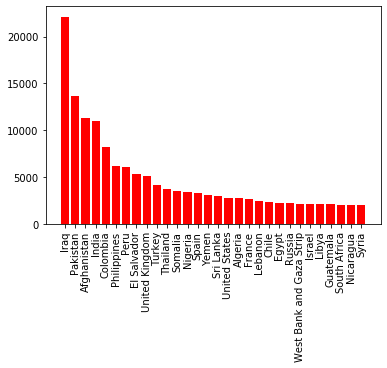

In [7]:
plt.bar(countries, terr_acts_counts, color="red", align='center')
plt.xticks(plt.xticks()[0], countries, rotation=90)
plt.show()

# Acts of terrorism in Russia

In [8]:
acts_in_russian = terrorism_table[(terrorism_table["country_txt"] == "Russia")]
acts_in_russian = acts_in_russian[
    ["targtype1_txt", "target1", "attacktype1_txt", "weaptype1_txt", "city", 
     "latitude", "longitude", "summary", "gname", "motive", "weapdetail", 
     "nkill"]
]
acts_in_russian["summary"] = acts_in_russian["summary"].apply(
    lambda value: fix_time_periods_in_string(value.replace("\xa0", " ").strip())
    if isinstance(value, str) else value
)

## Creating map

In [9]:
terror_acts_map = Map(location=[66.231457, 97.515678], zoom_start=3.1)
marker_cluster = MarkerCluster().add_to(terror_acts_map)

markers_count = 0

for row_idx in range(len(acts_in_russian)):
    row = acts_in_russian.iloc[row_idx]
    if not (row["latitude"] == row["latitude"] and row["longitude"] == row["longitude"]):
        continue
    
    get_marker_by_row(row).add_to(marker_cluster)
    markers_count += 1
    
print(markers_count)

2155


## Saving map

In [10]:
terror_acts_map.save("../html/terror_acts_map.html")